In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress
import xarray as xr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1. 
En la siguiente definición de modelo probabilístico cual es el likelihood, cual es el a priori y cual el a posteriori?

$$
y_i \sim Normal(\mu, \sigma)
$$
$$
\mu \sim Normal(0, 10)  
$$
$$
\sigma \sim HalfNormal(25)  
$$

La _likelihood_ es la probabilidad de los datos dado el modelo $p(y_i | \mu, \sigma)$, en este caso: $Likelihood \sim Normal(\mu, \sigma)$.  
Las distribuciones a priori de los parámetros serían $\mu \sim Normal(0, 10)$ y $\sigma \sim HalfNormal(25)$.  
La distribución _a posteriori_ es la probabilidad del modelo dado los datos $p(\mu, \sigma) = \frac{p(y_i | \mu, \sigma)p(\mu)p(\sigma)}{p(y_i)}$, en este caso creo que se puede calcular y da una Normal para $\mu$ al menos (HACER) 

# 2.
En el modelo del punto 1 ¿cuántos parámetros hay en el posterior? o expresado de otra forma ¿cuántas dimensiones tiene el a posteriori?

El _posterior_ es una distribución de dos dimensiones, una por parámetro.  
Sería la conjunta de las posteriors de $\mu$ y $\sigma$

# 4.
Usando el conjunto de datos ``howell`` (disponible junto con esta notebook) realice un modelo lineal del peso ($x$) versus la altura ($y$). Excluya a los menores de 18 años. Exponga los resultados.

In [2]:
howell = pd.read_csv('../datos/howell.csv', sep=';')

howell.head()

,altura,peso,edad,sexo
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
howell = howell[howell['edad'] >= 18]

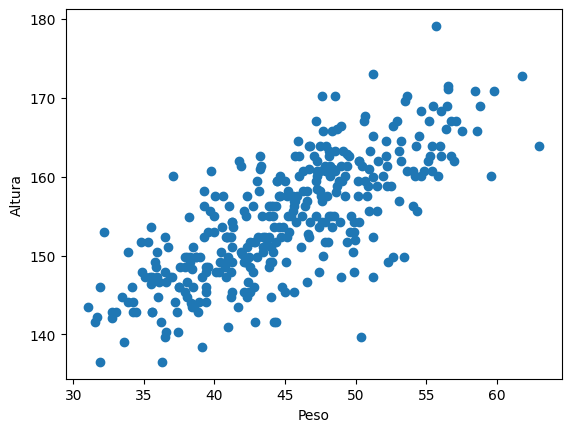

In [4]:
plt.scatter(howell['peso'], howell['altura'])
plt.xlabel('Peso')
plt.ylabel('Altura');

In [8]:
with pm.Model() as modelo_howell:
    intercepto = pm.Normal('intercepto', mu=0, sigma=10)
    pendiente = pm.Normal('pendiente', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = pm.Deterministic('mu', intercepto + pendiente * howell['peso'])
    
    altura = pm.Normal('altura', mu=mu, sigma=sigma, observed=howell['altura'])

In [9]:
with modelo_howell:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercepto, pendiente, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


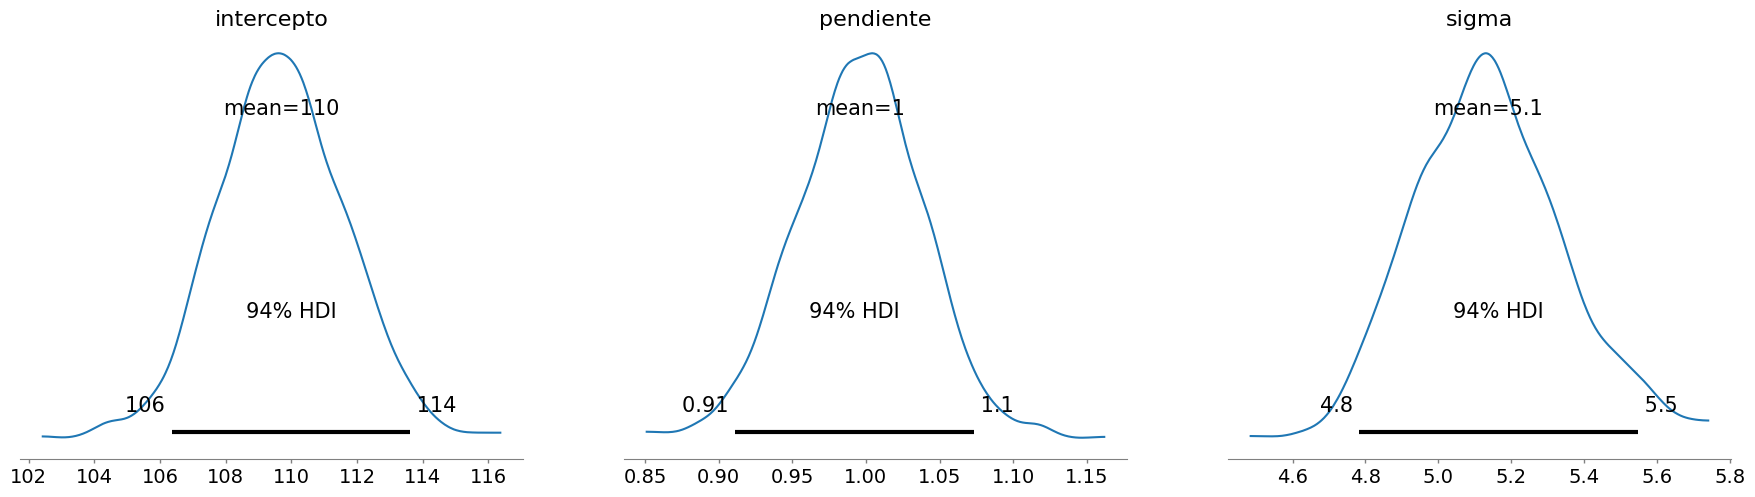

In [10]:
az.plot_posterior(idata, var_names=['intercepto', 'pendiente', 'sigma']);

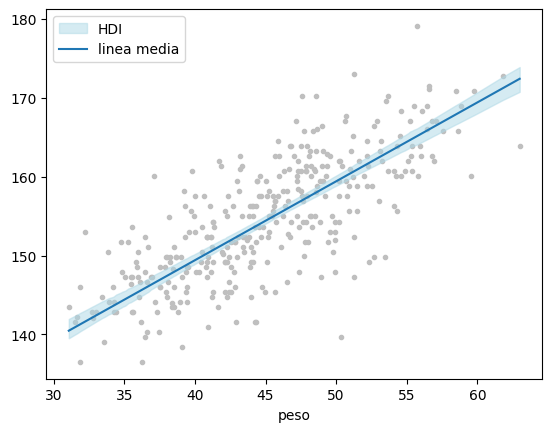

In [18]:
posterior = az.extract(idata, num_samples=50)
x_plot = xr.DataArray(np.linspace(howell.peso.min(), howell.peso.max(), 50), dims="plot_id")
linea_media = posterior['intercepto'].mean() + posterior['pendiente'].mean() * x_plot
hdi_lines = az.hdi(idata.posterior['mu'])


plt.plot(howell.peso, howell.altura, '.', color="0.75",  zorder=-3)
idx = np.argsort(howell.peso.values)
plt.fill_between(howell.peso.sort_values(), hdi_lines["mu"][:,0][idx], hdi_lines["mu"][:,1][idx],
                     color="lightblue", label='HDI', alpha=0.5)
plt.plot(x_plot, linea_media, c='C0', label='linea media')
plt.xlabel('peso')
plt.legend();

In [19]:
pm.sample_posterior_predictive(idata, model=modelo_howell, extend_inferencedata=True)

Sampling: [altura]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

No pude correr el codigo para graficar la posterior predictive

### con bambi

In [9]:
modelo_lineal = bmb.Model("altura ~ peso", howell)

In [10]:
modelo_lineal

       Formula: altura ~ peso
        Family: gaussian
          Link: mu = identity
  Observations: 352
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 154.5971, sigma: 136.2498)
            peso ~ Normal(mu: 0.0, sigma: 2.9978)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 7.7313)

In [11]:
idata = modelo_lineal.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [altura_sigma, Intercept, peso]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 271 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


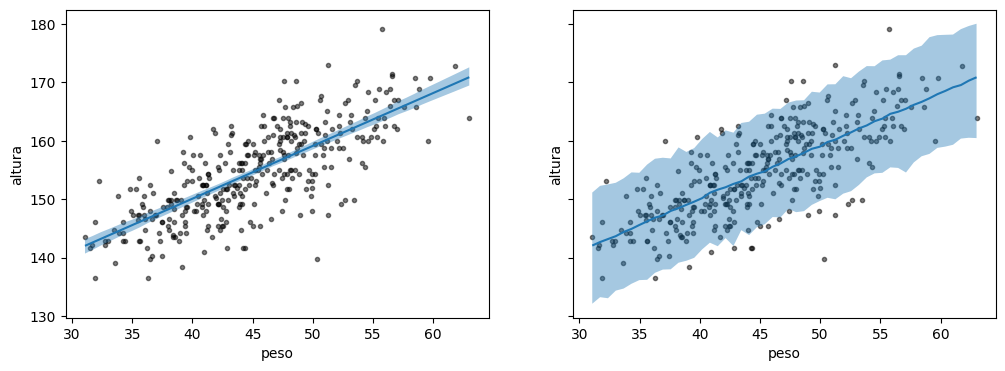

In [12]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
bmb.interpret.plot_predictions(modelo_lineal, idata, 'peso', ax=plt)
bmb.interpret.plot_predictions(modelo_lineal, idata, 'peso', pps=True, ax=plt)

plt.plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1)
plt.plot(howell['peso'], howell['altura'], '.', color='black', alpha=0.5, zorder=-1);

# 5. 
Para 4 individuos se registraron los pesos (45.73, 65.8, 54.2, 32.59), pero no las alturas. Usando el modelo del punto anterior prediga la altura esperada para cada individuo junto con un intervalo de credibilidad del 50% y del 89%.

In [48]:
with pm.Model() as modelo_howell:
    pesos = pm.MutableData('pesos', howell.peso.values.astype(float))
    intercepto = pm.Normal('intercepto', mu=0, sigma=10)
    pendiente = pm.Normal('pendiente', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = pm.Deterministic('mu', intercepto + pendiente * pesos)
    
    altura = pm.Normal('altura', mu=mu, sigma=sigma, observed=howell.altura)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercepto, pendiente, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [altura]
Sampling: [altura]
Sampling: [altura]
Sampling: [altura]


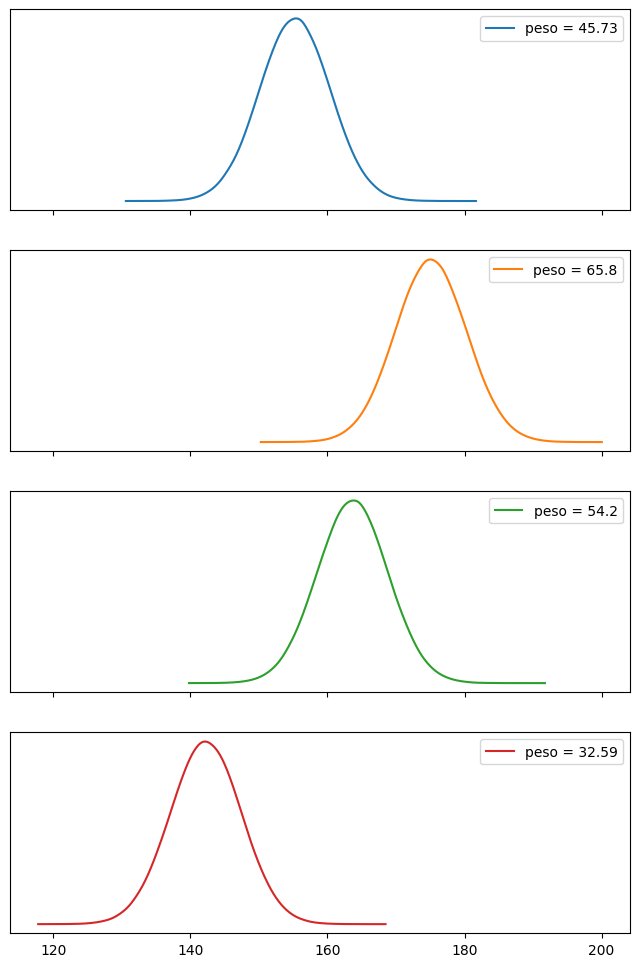

In [69]:
pesos = [45.73, 65.8, 54.2, 32.59]
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 12))

for i, peso in enumerate(pesos):
    with modelo_howell:
        pm.set_data({'pesos': [peso]})
        ppc = pm.sample_posterior_predictive(idata, progressbar=False)
        y_ppc = ppc.posterior_predictive['altura'].stack(sample=("chain", "draw"))
        grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
        ax[i].plot(grid, pdf, label=f'peso = {peso}', color=f'C{i}')
        ax[i].set_yticks([])
        ax[i].legend();


FALTAN LOS HDI